In [137]:
import os
import sys
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn import set_config
import joblib


In [118]:
#sys.path.append(os.path.abspath('../data'))
df = pd.read_csv("../data/processed/clean_data.csv", encoding = 'utf-8', encoding_errors="ignore")
(df.head())

,Unnamed: 0,Impressions,From Home,From Hashtags,From Explore,From Other,Saves,Comments,Shares,Likes,...,HashtagCount,HashtagDensity,FromHomeRatio,FromHashtagsRatio,FromExploreRatio,FromOtherRatio,IsWeekend,Month,HourOfDay,NumOfHashtags
0,0,3920,2586,1028,619,56,98,9,5,162,...,1,0.111111,0.659694,0.262245,0.157908,0.014286,0,5,22,22
1,1,5394,2727,1838,1174,78,194,7,14,224,...,1,0.055556,0.505562,0.340749,0.217649,0.014461,0,5,3,18
2,2,4021,2085,1188,0,533,41,11,1,131,...,1,0.071429,0.518528,0.295449,0.000000,0.132554,1,1,6,18
3,3,4528,2700,621,932,73,172,10,7,213,...,1,0.058824,0.596290,0.137147,0.205830,0.016122,0,6,16,11
4,4,2518,1704,255,279,37,96,5,4,123,...,1,0.062500,0.676728,0.101271,0.110802,0.014694,0,3,17,29


In [119]:
df = df.drop("Unnamed: 0", axis=1)

In [120]:
df.shape

(119, 28)

In [121]:
df.columns

Index(['Impressions', 'From Home', 'From Hashtags', 'From Explore',
       'From Other', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits',
       'Follows', 'Caption', 'Hashtags', 'Timestamp', 'Content Type',
       'CaptionLength', 'DayOfWeek', 'EngagementRate', 'HashtagCount',
       'HashtagDensity', 'FromHomeRatio', 'FromHashtagsRatio',
       'FromExploreRatio', 'FromOtherRatio', 'IsWeekend', 'Month', 'HourOfDay',
       'NumOfHashtags'],
      dtype='object')

In [123]:
cols = ['From Home', 'From Hashtags', 'From Explore',
       'From Other', 'Saves', 'Comments', 'Shares', 
       'Follows', 'EngagementRate', 'HashtagCount', 'FromHomeRatio',
        'FromHashtagsRatio', 'FromExploreRatio', 'FromOtherRatio',]
df = df.drop(labels=cols, axis=1)

In [124]:
df.head(2)

,Impressions,Likes,Profile Visits,Caption,Hashtags,Timestamp,Content Type,CaptionLength,DayOfWeek,HashtagDensity,IsWeekend,Month,HourOfDay,NumOfHashtags
0,3920,162,35,important data visualization every financial d...,#finance#money#business#investing#investment#t...,2024-05-14 22:59:29.747899160,carousel,8,1,0.111111,0,5,22,22
1,5394,224,48,best data science project idea healthcare want...,#healthcare#health#covid#data#datascience#data...,2024-05-24 03:49:54.957983192,carousel,17,4,0.055556,0,5,3,18


In [125]:
df.columns, df.shape

(Index(['Impressions', 'Likes', 'Profile Visits', 'Caption', 'Hashtags',
        'Timestamp', 'Content Type', 'CaptionLength', 'DayOfWeek',
        'HashtagDensity', 'IsWeekend', 'Month', 'HourOfDay', 'NumOfHashtags'],
       dtype='object'),
 (119, 14))

In [126]:
label_enc = LabelEncoder()
df["Content Type"] = label_enc.fit_transform(df["Content Type"])

In [127]:
joblib.dump(value=label_enc, filename="../models/ct_label_enc.pkl")

['../models/ct_label_enc.pkl']

In [128]:
df.columns

Index(['Impressions', 'Likes', 'Profile Visits', 'Caption', 'Hashtags',
       'Timestamp', 'Content Type', 'CaptionLength', 'DayOfWeek',
       'HashtagDensity', 'IsWeekend', 'Month', 'HourOfDay', 'NumOfHashtags'],
      dtype='object')

In [129]:
df.head()

,Impressions,Likes,Profile Visits,Caption,Hashtags,Timestamp,Content Type,CaptionLength,DayOfWeek,HashtagDensity,IsWeekend,Month,HourOfDay,NumOfHashtags
0,3920,162,35,important data visualization every financial d...,#finance#money#business#investing#investment#t...,2024-05-14 22:59:29.747899160,0,8,1,0.111111,0,5,22,22
1,5394,224,48,best data science project idea healthcare want...,#healthcare#health#covid#data#datascience#data...,2024-05-24 03:49:54.957983192,0,17,4,0.055556,0,5,3,18
2,4021,131,62,learn train machine learning model giving inpu...,#data#datascience#dataanalysis#dataanalytics#d...,2024-01-13 06:27:13.613445378,1,13,5,0.071429,1,1,6,18
3,4528,213,23,here write python program detect whether sente...,#python#pythonprogramming#pythonprojects#pytho...,2024-06-17 16:44:22.184873950,0,16,0,0.058824,0,6,16,11
4,2518,123,8,plotting annotation visualizing data considere...,#datavisualization#datascience#data#dataanalyt...,2024-03-20 17:56:58.487394958,2,15,2,0.062500,0,3,17,29


In [95]:
num_pipeline_columns = ['Impressions', 'Likes', 'Profile Visits',
       'Timestamp', 'CaptionLength', 'DayOfWeek', 'HashtagCount',
       'HashtagDensity', 'IsWeekend', 'Month', 'HourOfDay', 'NumOfHashtags']

In [130]:
def to_datetime(X):
    return pd.to_datetime(X.squeeze(), errors='coerce').values.astype('datetime64[s]').reshape(-1, 1)

timestamp_transformer = FunctionTransformer(to_datetime)


In [ ]:
text_features = ['Caption', 'Hashtags']
scale_features = ['CaptionLength', 'DayOfWeek', 'Month',
                  'HourOfDay', 'NumOfHashtags']
passthrough_features = ['HashtagDensity', 'IsWeekend', 'Content Type']
timestamp_feature = ['Timestamp']

In [134]:
preprocessor = ColumnTransformer(
    transformers=[
        ('timestamp', timestamp_transformer, timestamp_feature),
        ('text', TfidfVectorizer(), 'Caption'),  
        ('hashtags', TfidfVectorizer(), 'Hashtags'),  
        ('scale', StandardScaler(), scale_features),
        ('pass', 'passthrough', passthrough_features)
    ]
)

In [135]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [136]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__subsample': [0.8, 1.0]
}

In [138]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

In [115]:
sys.path.append(os.path.abspath('../'))

# for impressions 

In [139]:
y_imp =     df["Impressions"]
y_likes = df["Likes"]
y_profile = df["Profile Visits"]

In [140]:
input_cols = [ 'CaptionLength','Timestamp', 'DayOfWeek', 
              'HashtagDensity', 'IsWeekend',
                'Month','HourOfDay', 'Content Type',
                'NumOfHashtags', 'Caption', 'Hashtags'
]

In [141]:
X = df[input_cols]
X.head()

,CaptionLength,Timestamp,DayOfWeek,HashtagDensity,IsWeekend,Month,HourOfDay,Content Type,NumOfHashtags,Caption,Hashtags
0,8,2024-05-14 22:59:29.747899160,1,0.111111,0,5,22,0,22,important data visualization every financial d...,#finance#money#business#investing#investment#t...
1,17,2024-05-24 03:49:54.957983192,4,0.055556,0,5,3,0,18,best data science project idea healthcare want...,#healthcare#health#covid#data#datascience#data...
2,13,2024-01-13 06:27:13.613445378,5,0.071429,1,1,6,1,18,learn train machine learning model giving inpu...,#data#datascience#dataanalysis#dataanalytics#d...
3,16,2024-06-17 16:44:22.184873950,0,0.058824,0,6,16,0,11,here write python program detect whether sente...,#python#pythonprogramming#pythonprojects#pytho...
4,15,2024-03-20 17:56:58.487394958,2,0.062500,0,3,17,2,29,plotting annotation visualizing data considere...,#datavisualization#datascience#data#dataanalyt...


In [143]:
imp_model = grid_search.fit(X, y_imp)
imp_model.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


ValueError: 
All the 270 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Content_Type_enc'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'Content_Type_enc'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


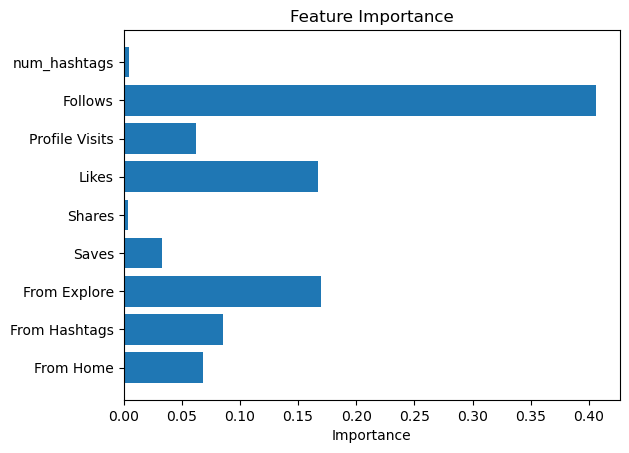

In [ ]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
features = x.columns
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()
